# Caso de estudio en Analítica de Datos

## Estudio de información histórica del ICFES Pruebas Saber 11 en Colombia

### Índice


1. [Introducción](#intro)

2. [Obtención, limpieza y transformación de datos (ETL)](#p2) 

3. [Exploración preliminar de datos](#p3)

4. [Análisis de selección de modelos de _machine learning_](#p4)

5. [Herramienta interactiva de visualización (_dashboard_)](#p5)

6. [Conclusiones](#p6)

7. [Referencias](#p7)

Autor: Luis González

Correo: luisf.gonzalezv@yahoo.com



<a id="intro"></a>
## 1.Introducción
---
El presente es un estudio de caso en _analytics_ que desarrollé como parte de mi formación en la Maestría en Analítica de Datos de la Universidad de los Andes. En él, exploro la información que cada semestre se recoge sobre los estudiantes que presentan sus pruebas Saber 11 por el ICFES.


El ICFES (Instituto Colombiano para el Fomento de la Educación Superior) está adscrito al Ministerio de Educación a nivel nacional. Como parte de sus funciones, el ICFES administra las pruebas Saber 11, las cuales evalúan a todos los estudiantes del país al final de su educación secundaria. El examen contiene preguntas que evalúan una variedad de áreas del conocimiento (ej., matemáticas, física, inglés, etc.) y se lleva a cabo dos veces al año, ajustándose a los diferentes calendarios académicos que siguen las instituciones educativas. Al momento de inscribirse a las pruebas, los estudiantes diligencian un formulario que recoge información sociodemográfica y relacionada con la institución a la que pertenecen. El fin es obtener información con respecto al desempeño de los estudiantes en la prueba y de sus características.

Al igual que otros países de la región, Colombia tiene grandes retos en términos de desigualdad, particularmente en el contexto de educación primaria y secundaria. Por esta razón, para el Estado colombiano es muy valioso el amplio registro de datos que el ICFES genera alrededor de las pruebas Saber 11, pues con ellos se pueden generar análisis sobre la calidad de la educación en el país y eventualmente dar lugar a recomendaciones sobre políticas públicas. En particular, la problemática a abordar en este caso de estudio es la desigualdad y factores de éxito en las pruebas Saber 11. 

Los objetivos de este caso de estudio son:

* Entender el contenido de los archivos de datos proporcionados sobre las pruebas Saber 11, generar un reporte acerca de sus características principales y seleccionar las partes de dicho contenido que podrían ser relevantes para el análisis.


* Identificar características de las variables de interés y relaciones entre ellas, por ejemplo, a través de agrupación, visualizaciones y estadísticas descriptivas.


* Proponer modelos de _machine learning_ que busquen relacionar las variables de interés con el desempeño de los estudiantes y concluir acerca de los posibles hallazgos que se podrían reportar para el *stakeholder*.


* Generar una herramienta interactiva de visualización que permita a un usuario interactuar con alguno de los parámetros del análisis realizado de forma relevante en el contexto del problema.

* Concluir acerca de los factores que más impactan el desempeño académico de los estudiantes en Colombia.

<a id="p2"></a>
## 2. Obtención, limpieza y transformación de datos (ETL)

-- --- --- ---

Para obtener los datos se siguió el siguiente proceso (para asegurar replicabilidad):
1. Acceder a https://www.icfes.gov.co/data-icfes, y registrarse con correo para tener acceso a los datos.
2. Una vez se ingresa con usuario, se tiene acceso a un repositorio de datos en OneDrive. Éste se navegó de la siguiente forma:
* Se escoge la carpeta `04. Saber11`.
* La carpeta tiene varias subcarpetas. La más relevante para la actual investigación es `3. Resultados Saber11`. Dentro de dicha carpeta, se tienen carpetas comprimidas con los resultados de las pruebas nacionales en cada semestre, desde el primer semestre del 2001 hasta el primer semestre del 2023 (a la fecha de realización de esta actividad). 
* Se procede a descargar las carpetas de las últimas 4 pruebas más recientes. Esto es, desde el segundo semestre de 2021 hasta el primer semestre del 2023. Cada carpeta contiene un archivo de texto, los cuales se procede a ubicar en el directorio de trabajo. 

### Nota:
El _notebook_ tiene una extensión considerable, por lo que correr todas las celdas en simultáneo puede llenar fácilmente la memoria temporal del computador. Se sugiere a quien corra este documento en local reabrirlo nuevamente para cada fase, con el objetivo de liberar memoria.

In [28]:
# librerías fase 1
import pandas as pd
import numpy as np
import re
from random import sample

Como este estudio se pretende trabajar usando pandas, es importante usar un volumen limitado de datos, ya que originalmente se tiene más de un millón de observaciones. Se procede a trabajar solamente con el 5% del total de los datos, dando igual representación a los estudiantes de cada periodo estudiado (5% por cada archivo).

Cabe mencionar una leve discrepancia entre los datos, ya que unos archivos tienen ciertas columnas adicionales que otros no. Para solucionar esto, se unen las bases de datos sólo en las columnas comunes a todos los arcchivos.

In [29]:
# esta celda toma alrededor de 2 minutos en completarse. Se recomienda correr una vez, luego guardar
# como .csv para posterior acceso más rápidamente
# descomentar las apóstrofes para evitar correr
#"""
# importar los datos, se especifica engine porque el separador no es utf-8
archivos=["SB11_20222.txt", "SB11_20221.txt", "SB11_20212.txt"]
df=pd.read_csv("Archivos/SB11_20231.txt", delimiter="¬", engine="python") # este df tiene el menor num de columnas (81, entonces es la base)
# tomar una muestra aleatoria de los datos
muestra = int(0.05 * len(df))
df = df.sample(muestra, random_state=42)

for i in archivos: #los demás archivos, que tienen más columnas
    path="Archivos/"+i
    df_provisional=pd.read_csv(path, delimiter="¬", engine="python")
    muestra = int(0.05 * len(df_provisional))
    muestra_df = df_provisional.sample(muestra, random_state=42)
    # unir registros al df
    df = pd.concat([df, muestra_df], ignore_index=True) # por default, se encajan las columnas de mismo nombre (las demás son NaN)
df.shape
#"""

(54564, 86)

In [30]:
# eliminar columnas problemáticas al importar datos (descontinuadas para 2023-1)
cols=['ESTU_PRESENTACIONSABADO', 'SEED_NOMBRE', 'ESTU_AGREGADO', 'ESTU_GENERACION-E']
df.drop(cols, axis=1, inplace=True)

Se procede a analizar los datos de forma preliminar.

In [31]:
df.head()

,ESTU_TIPODOCUMENTO,ESTU_NACIONALIDAD,ESTU_GENERO,ESTU_FECHANACIMIENTO,PERIODO,ESTU_CONSECUTIVO,ESTU_ESTUDIANTE,ESTU_PAIS_RESIDE,ESTU_TIENEETNIA,ESTU_DEPTO_RESIDE,...,PUNT_INGLES,PERCENTIL_INGLES,DESEMP_INGLES,PUNT_GLOBAL,PERCENTIL_GLOBAL,PERCENTIL_ESPECIAL_GLOBAL,ESTU_ESTADOINVESTIGACION,ESTU_INSE_INDIVIDUAL,ESTU_NSE_INDIVIDUAL,ESTU_NSE_ESTABLECIMIENTO
0,TI,COLOMBIA,M,21/06/2005,20231,SB11202310023286,ESTUDIANTE,COLOMBIA,No,CAUCA,...,56.0,41.0,A1,298,55.0,NaN,PUBLICAR,NaN,NaN,NaN
1,TI,COLOMBIA,F,30/03/2006,20231,SB11202310018777,ESTUDIANTE,COLOMBIA,No,VALLE,...,60.0,46.0,A2,317,65.0,NaN,PUBLICAR,NaN,NaN,NaN
2,TI,COLOMBIA,M,11/07/2006,20231,SB11202310016686,ESTUDIANTE,COLOMBIA,No,VALLE,...,55.0,39.0,A1,244,31.0,NaN,PUBLICAR,NaN,NaN,NaN
3,TI,COLOMBIA,M,28/11/2005,20231,SB11202310023109,ESTUDIANTE,COLOMBIA,No,VALLE,...,49.0,27.0,A1,291,52.0,NaN,PUBLICAR,NaN,NaN,NaN
4,TI,COLOMBIA,M,18/10/2006,20231,SB11202310009686,ESTUDIANTE,COLOMBIA,No,VALLE,...,84.0,89.0,B+,413,100.0,NaN,PUBLICAR,NaN,NaN,NaN


In [32]:
df.columns

Index(['ESTU_TIPODOCUMENTO', 'ESTU_NACIONALIDAD', 'ESTU_GENERO',
       'ESTU_FECHANACIMIENTO', 'PERIODO', 'ESTU_CONSECUTIVO',
       'ESTU_ESTUDIANTE', 'ESTU_PAIS_RESIDE', 'ESTU_TIENEETNIA',
       'ESTU_DEPTO_RESIDE', 'ESTU_COD_RESIDE_DEPTO', 'ESTU_MCPIO_RESIDE',
       'ESTU_COD_RESIDE_MCPIO', 'FAMI_ESTRATOVIVIENDA', 'FAMI_PERSONASHOGAR',
       'FAMI_CUARTOSHOGAR', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE',
       'FAMI_TRABAJOLABORPADRE', 'FAMI_TRABAJOLABORMADRE',
       'FAMI_TIENEINTERNET', 'FAMI_TIENESERVICIOTV', 'FAMI_TIENECOMPUTADOR',
       'FAMI_TIENELAVADORA', 'FAMI_TIENEHORNOMICROOGAS', 'FAMI_TIENEAUTOMOVIL',
       'FAMI_TIENEMOTOCICLETA', 'FAMI_TIENECONSOLAVIDEOJUEGOS',
       'FAMI_NUMLIBROS', 'FAMI_COMELECHEDERIVADOS',
       'FAMI_COMECARNEPESCADOHUEVO', 'FAMI_COMECEREALFRUTOSLEGUMBRE',
       'FAMI_SITUACIONECONOMICA', 'ESTU_DEDICACIONLECTURADIARIA',
       'ESTU_DEDICACIONINTERNET', 'ESTU_HORASSEMANATRABAJA',
       'ESTU_TIPOREMUNERACION', 'COLE_CODIGO_ICFES',


Se observa que se tienen observaciones para 54564 estudiantes, cada una con 82 atributos. Observando los datos, se ven ciertos problemas iniciales:
* Muchas de ellas probablemente otorgan información redundante o de ningún valor para el presente ejercicio. Por ejemplo, las columnas  `FAMI_TIENEINTERNET`, `FAMI_TIENESERVICIOTV`, `FAMI_TIENECOMPUTADOR`, entre otras, están relacionadas con el nivel socioeconómico de la familia del estudiante. 
* Columnas de una sola categoría homogénea, o que incluyen códigos, tampoco son de valor.
* Columnas que tengan principalmente datos vacíos, producto de la integración de las bases de datos.

Por último, se observan tres grandes grupos de columnas: Las que comienzan por "FAMI", "ESTU" y "COLE".
Se definirán funciones que permitan analizar las columnas de forma eficiente.

In [6]:
# esta función muestra cuantas columnas empiezan por la clave ingresada, y despliega un índice para posterior
# revisión
def subgrupos(texto=str):
    columnas=list(df.columns)
    pat="^"+texto #patrón de expresiones regulares
    global sub_cols
    sub_cols = [col for col in columnas if re.search(pat, col)] #comprensión de listas
    print("En total hay "+str(len(sub_cols))+ " columnas que comienzan por la clave: "+texto)
    print ("A continuación se muestran según su índice:")
    print("--- --- --- --- ")
    for i in range(0, len(sub_cols)):
        print (str(i)+" : "+ sub_cols[i])
    return None

In [34]:
# esta función otorga una descripción de la columna indicada, según el índice otorgado en la
# función subgrupos
def estudiar_columna(indice):
    col=sub_cols[indice]
    print (df[col].value_counts())
    return None

In [7]:
# esta función borra todas las columnas que se están estudiando en la función subgrupos, 
# a excepción de las columnas que se ingresen como parámetro en una lista
def guardar_variables(df, cols=list):
    ini=df.shape[1]
    for i in cols:
        try:
            sub_cols.remove(i)
        except: continue
    df.drop(sub_cols, axis=1, inplace=True)
    fin=df.shape[1]
    elim=ini-fin
    print("Se eliminaron en total "+str(elim)+ " columnas.")

Ahora, se hace uso de las funciones.

In [36]:
subgrupos("FAMI")

En total hay 20 columnas que comienzan por la clave: FAMI
A continuación se muestran según su índice:
--- --- --- --- 
0 : FAMI_ESTRATOVIVIENDA
1 : FAMI_PERSONASHOGAR
2 : FAMI_CUARTOSHOGAR
3 : FAMI_EDUCACIONPADRE
4 : FAMI_EDUCACIONMADRE
5 : FAMI_TRABAJOLABORPADRE
6 : FAMI_TRABAJOLABORMADRE
7 : FAMI_TIENEINTERNET
8 : FAMI_TIENESERVICIOTV
9 : FAMI_TIENECOMPUTADOR
10 : FAMI_TIENELAVADORA
11 : FAMI_TIENEHORNOMICROOGAS
12 : FAMI_TIENEAUTOMOVIL
13 : FAMI_TIENEMOTOCICLETA
14 : FAMI_TIENECONSOLAVIDEOJUEGOS
15 : FAMI_NUMLIBROS
16 : FAMI_COMELECHEDERIVADOS
17 : FAMI_COMECARNEPESCADOHUEVO
18 : FAMI_COMECEREALFRUTOSLEGUMBRE
19 : FAMI_SITUACIONECONOMICA


Para no saturar de líneas de código al notebook, se reciclará la siguiente línea de código con la cual se examinan las columnas a más detenimiento.

In [37]:
estudiar_columna(5)

FAMI_TRABAJOLABORPADRE
Es agricultor, pesquero o jornalero                                                                     7031
Trabaja por cuenta propia (por ejemplo plomero, electricista)                                           6478
Es operario de máquinas o conduce vehículos (taxita, chofer)                                            5257
No aplica                                                                                               4671
No sabe                                                                                                 4668
Trabaja como profesional (por ejemplo médico, abogado, ingeniero)                                       4562
Es dueño de un negocio pequeño (tiene pocos empleados o no tiene, por ejemplo tienda, papelería, etc    4244
Trabaja como personal de limpieza, mantenimiento, seguridad o construcción                              3802
Trabaja en el hogar, no trabaja o estudia                                                               3


Un factor que complica la decisión de qué variables conservar es el hecho que casi todas las variables son categóricas, y no se puede usar el método `.corr()` de forma directa para verificar correlaciones. Según lo observado con la función anterior, se procede a eliminar todas las columnas, a excepción de la considerada más indicativas del estado económico del estudiante, que es `FAMI_ESTRATOVIVIENDA `.

In [38]:
utiles=["FAMI_ESTRATOVIVIENDA"]
guardar_variables(df, utiles)

Se eliminaron en total 19 columnas.


Ahora, se procede a estudiar las columnas que empiezan por "ESTU" y "COLE", con el mismo proceso realizado anteriormente para las columnas "FAMI".

In [39]:
subgrupos("ESTU")

En total hay 25 columnas que comienzan por la clave: ESTU
A continuación se muestran según su índice:
--- --- --- --- 
0 : ESTU_TIPODOCUMENTO
1 : ESTU_NACIONALIDAD
2 : ESTU_GENERO
3 : ESTU_FECHANACIMIENTO
4 : ESTU_CONSECUTIVO
5 : ESTU_ESTUDIANTE
6 : ESTU_PAIS_RESIDE
7 : ESTU_TIENEETNIA
8 : ESTU_DEPTO_RESIDE
9 : ESTU_COD_RESIDE_DEPTO
10 : ESTU_MCPIO_RESIDE
11 : ESTU_COD_RESIDE_MCPIO
12 : ESTU_DEDICACIONLECTURADIARIA
13 : ESTU_DEDICACIONINTERNET
14 : ESTU_HORASSEMANATRABAJA
15 : ESTU_TIPOREMUNERACION
16 : ESTU_PRIVADO_LIBERTAD
17 : ESTU_COD_MCPIO_PRESENTACION
18 : ESTU_MCPIO_PRESENTACION
19 : ESTU_DEPTO_PRESENTACION
20 : ESTU_COD_DEPTO_PRESENTACION
21 : ESTU_ESTADOINVESTIGACION
22 : ESTU_INSE_INDIVIDUAL
23 : ESTU_NSE_INDIVIDUAL
24 : ESTU_NSE_ESTABLECIMIENTO


In [40]:
num=1
estudiar_columna(num)

ESTU_NACIONALIDAD
COLOMBIA          53919
VENEZUELA           609
ESTADOS UNIDOS        6
ECUADOR               6
ESPAÑA                5
VANUATU               4
CHINA                 3
SUECIA                2
PANAMÁ                2
EL SALVADOR           1
ITALIA                1
MÉXICO                1
HONDURAS              1
ARGENTINA             1
URUGUAY               1
CUBA                  1
COSTA RICA            1
Name: count, dtype: int64


Se observa que ciertas columnas aportan códigos, los cuales no son de interés para el análisis, y otras aportan información de poco valor. Por ejemplo, la columna `ESTU_PRIVADO_LIBERTAD` sería de interés, pero casi ningún estudiante respondió "Sí", por lo cual la muestra es homogénea en este aspecto y las comparaciones realizadas serían de poco valor. Se procede a conservar las columnas , `ESTU_GENERO`, `ESTU_TIENEETNIA`, `ESTU_DEPTO_RESIDE`, `ESTU_DEDICACIONLECTURADIARIA`, `ESTU_DEDICACIONINTERNET`, y `ESTU_HORASSEMANATRABAJA` .


In [41]:
utiles=["ESTU_DEPTO_RESIDE", "ESTU_GENERO", "ESTU_TIENEETNIA", "ESTU_DEDICACIONLECTURADIARIA", "ESTU_DEDICACIONINTERNET", "ESTU_HORASSEMANATRABAJA"]
guardar_variables(df, utiles)

Se eliminaron en total 19 columnas.


Ahora, se analizan las variables que inician por "COLE":

In [42]:
subgrupos("COLE")

En total hay 17 columnas que comienzan por la clave: COLE
A continuación se muestran según su índice:
--- --- --- --- 
0 : COLE_CODIGO_ICFES
1 : COLE_COD_DANE_ESTABLECIMIENTO
2 : COLE_NOMBRE_ESTABLECIMIENTO
3 : COLE_GENERO
4 : COLE_NATURALEZA
5 : COLE_CALENDARIO
6 : COLE_BILINGUE
7 : COLE_CARACTER
8 : COLE_COD_DANE_SEDE
9 : COLE_NOMBRE_SEDE
10 : COLE_SEDE_PRINCIPAL
11 : COLE_AREA_UBICACION
12 : COLE_JORNADA
13 : COLE_COD_MCPIO_UBICACION
14 : COLE_MCPIO_UBICACION
15 : COLE_COD_DEPTO_UBICACION
16 : COLE_DEPTO_UBICACION


In [43]:
num=7
estudiar_columna(num)

COLE_CARACTER
ACADÉMICO            27924
TÉCNICO/ACADÉMICO    17807
TÉCNICO               6074
NO APLICA              813
Name: count, dtype: int64


Según los razonamientos descritos previamente, se procede a conservar las columnas de utilidad. 

In [44]:
utiles=["COLE_GENERO", "COLE_BILINGUE", "COLE_CARACTER", "COLE_JORNADA", "COLE_CALENDARIO"]
guardar_variables(df, utiles)

Se eliminaron en total 12 columnas.


Ahora, se procede a examinar nuevamente la base de datos:

In [45]:
df.columns

Index(['ESTU_GENERO', 'PERIODO', 'ESTU_TIENEETNIA', 'ESTU_DEPTO_RESIDE',
       'FAMI_ESTRATOVIVIENDA', 'ESTU_DEDICACIONLECTURADIARIA',
       'ESTU_DEDICACIONINTERNET', 'ESTU_HORASSEMANATRABAJA', 'SEED_CODIGOMEN',
       'COLE_GENERO', 'COLE_CALENDARIO', 'COLE_BILINGUE', 'COLE_CARACTER',
       'COLE_JORNADA', 'PUNT_LECTURA_CRITICA', 'PERCENTIL_LECTURA_CRITICA',
       'DESEMP_LECTURA_CRITICA', 'PUNT_MATEMATICAS', 'PERCENTIL_MATEMATICAS',
       'DESEMP_MATEMATICAS', 'PUNT_C_NATURALES', 'PERCENTIL_C_NATURALES',
       'DESEMP_C_NATURALES', 'PUNT_SOCIALES_CIUDADANAS',
       'PERCENTIL_SOCIALES_CIUDADANAS', 'DESEMP_SOCIALES_CIUDADANAS',
       'PUNT_INGLES', 'PERCENTIL_INGLES', 'DESEMP_INGLES', 'PUNT_GLOBAL',
       'PERCENTIL_GLOBAL', 'PERCENTIL_ESPECIAL_GLOBAL'],
      dtype='object')

Se revisan los datos vacíos según columna y porcentaje:

In [46]:
def calcular_faltantes(df):
    faltantes=df.isna().sum().sort_values(ascending=False)
    faltantes=faltantes[faltantes > 0]
    faltantes=faltantes/df.shape[0]
    return faltantes
calcular_faltantes(df)

SEED_CODIGOMEN                  0.988362
PERCENTIL_ESPECIAL_GLOBAL       0.977018
COLE_BILINGUE                   0.173961
FAMI_ESTRATOVIVIENDA            0.060754
ESTU_DEDICACIONINTERNET         0.057052
ESTU_DEDICACIONLECTURADIARIA    0.054651
ESTU_HORASSEMANATRABAJA         0.037167
COLE_CARACTER                   0.035665
PUNT_INGLES                     0.005150
PERCENTIL_GLOBAL                0.005150
DESEMP_INGLES                   0.005150
PERCENTIL_INGLES                0.005150
ESTU_TIENEETNIA                 0.002291
ESTU_DEPTO_RESIDE               0.000073
ESTU_GENERO                     0.000055
dtype: float64

Se procede a eliminar las primeras dos columnas, pues casi todos sus registros son vacíos.

In [47]:
df=df.drop(columns=["PERCENTIL_ESPECIAL_GLOBAL", "SEED_CODIGOMEN"], index=1)
df.shape

(54563, 30)

Para las demás columnas, se observa que en general el porcentaje de nulos es bajo (inferior al 20%). Como se tiene un alto número de registros, se asume que el análisis no se verá muy afectado si se eliminan las filas con nulos.

In [48]:
df.dropna(inplace=True)
df.shape

(41064, 30)

In [49]:
calcular_faltantes(df) #(ya no hay faltantes)

Series([], dtype: float64)

Eliminar las filas con al menos un atributo nulo resultó en una pérdida de información del 25% en la base de datos, lo cual se considera aceptable dentro del alcance de este trabajo. 

Existen ciertas columnas que siguen sin ser estudiadas, se procede a  profundizar más en ellas:

In [50]:
subgrupos("PUNT")

En total hay 6 columnas que comienzan por la clave: PUNT
A continuación se muestran según su índice:
--- --- --- --- 
0 : PUNT_LECTURA_CRITICA
1 : PUNT_MATEMATICAS
2 : PUNT_C_NATURALES
3 : PUNT_SOCIALES_CIUDADANAS
4 : PUNT_INGLES
5 : PUNT_GLOBAL


In [51]:
estudiar_columna(1)

PUNT_MATEMATICAS
51    1383
49    1370
52    1365
53    1362
54    1319
      ... 
17       4
84       3
16       2
0        1
15       1
Name: count, Length: 72, dtype: int64


In [52]:
subgrupos("DESEMP")

En total hay 5 columnas que comienzan por la clave: DESEMP
A continuación se muestran según su índice:
--- --- --- --- 
0 : DESEMP_LECTURA_CRITICA
1 : DESEMP_MATEMATICAS
2 : DESEMP_C_NATURALES
3 : DESEMP_SOCIALES_CIUDADANAS
4 : DESEMP_INGLES


In [53]:
estudiar_columna(1)

DESEMP_MATEMATICAS
3    19218
2    15342
1     4246
4     2258
Name: count, dtype: int64


Se observa que para las materias lectura crítica, matemáticas, ciencias naturales, sociales y ciudadanas e inglés, las columnas "DESEMP" y "PUNT" difieren sólamente en que la primera caracteriza a los estudiantes por niveles de rendimiento categóricos, del 1 al 4, mientras que la segunda otorga el puntaje exacto en cada prueba. Se procede a eliminar las columnas de "DESEMP", para reducir lo más posible la base de datos. El _binning_ puede, en todo caso, restituirse mediante código de ser necesario.

In [54]:
guardar_variables(df, [])

Se eliminaron en total 5 columnas.


Se consideran las columnas faltantes sin examinar:

In [55]:
sub_cols=["PERIODO"]
num=0
estudiar_columna(num)

PERIODO
20214    20364
20224    19699
20221      517
20231      484
Name: count, dtype: int64


Esta columna identifica el periodo de evaluación de la prueba, lo cual es de interés para el análisis exploratorio. Se observa que hay muchos más datos para las pruebas del primer segundo semestre del año que para el segundo.

In [56]:
sub_cols=["COLE_CALENDARIO"]
num=0
estudiar_columna(num)

COLE_CALENDARIO
A       39931
B        1046
OTRO       87
Name: count, dtype: int64


Esto se explica porque se registran muchos más colegios de calendario A, los cuales presentan pruebas Saber en el segundo semestre del año. 

Una última consideración es eliminar las observaciones con niveles no válidos para el análisis. Por ejemplo, para el estrato de la vivienda, no es muy útil analizar los estudiantes que respondieron "Sin Estrato". Se eliminan estas observaciones.

In [57]:
# eliminar niveles no válidos para variables multiclase
df = df[df['COLE_CARACTER'] != "NO APLICA"] # borrar el nivel "no aplica" para COLE_CARACTER
df = df[df['FAMI_ESTRATOVIVIENDA'] != "Sin Estrato"] # borrar el nivel "no aplica" para estrato

In [58]:
df.shape

(39660, 25)

Con esto, se concluye la primera fase de ETL (Extract, Transform, Load) de los datos. Se conservaron 39660 observaciones de estudiantes y 25 atributos de 82 posibles sobre su información socieconómica (estrato, información sobre el colegio, nacionalidad) y su desempeño en las pruebas Saber 11 del primer semestre del 2023 (puntaje por materia, puntaje global, percentil global).

In [59]:
# esta celda es para guardar el progreso de la manipulación de la base de datos (de ser necesario),
# para facilitar retomar el proceso más tarde

df.to_csv("datos.csv", index=False) 



<a id="p3"></a>
## 3. Exploración preliminar de datos
--- ---

In [1]:
# librerías fase 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# descargar datos fase 1 (opcional)
df=pd.read_csv("datos.csv")

Para la realización de las estadísticas descriptivas, en primer lugar, es conveniente separar las variables numéricas de las categóricas.

In [3]:
df['PERIODO'] = df['PERIODO'].astype(object) # esta columna se identifica inicialmente como numérica

numericas = df.select_dtypes(include=['int64', 'float64'])
categoricas = df.select_dtypes(include='object')

# generar subconjuntos de los datos
df_num = df[numericas.columns]
df_cat = df[categoricas.columns]
print ("Variables numéricas: ")
print(numericas.columns)
print ("--- --- ---")
print("Variables categóricas: ")
print (categoricas.columns)


Variables numéricas: 
Index(['PUNT_LECTURA_CRITICA', 'PERCENTIL_LECTURA_CRITICA', 'PUNT_MATEMATICAS',
       'PERCENTIL_MATEMATICAS', 'PUNT_C_NATURALES', 'PERCENTIL_C_NATURALES',
       'PUNT_SOCIALES_CIUDADANAS', 'PERCENTIL_SOCIALES_CIUDADANAS',
       'PUNT_INGLES', 'PERCENTIL_INGLES', 'PUNT_GLOBAL', 'PERCENTIL_GLOBAL'],
      dtype='object')
--- --- ---
Variables categóricas: 
Index(['ESTU_GENERO', 'PERIODO', 'ESTU_TIENEETNIA', 'ESTU_DEPTO_RESIDE',
       'FAMI_ESTRATOVIVIENDA', 'ESTU_DEDICACIONLECTURADIARIA',
       'ESTU_DEDICACIONINTERNET', 'ESTU_HORASSEMANATRABAJA', 'COLE_GENERO',
       'COLE_CALENDARIO', 'COLE_BILINGUE', 'COLE_CARACTER', 'COLE_JORNADA'],
      dtype='object')


In [4]:
df_num.corr()

,PUNT_LECTURA_CRITICA,PERCENTIL_LECTURA_CRITICA,PUNT_MATEMATICAS,PERCENTIL_MATEMATICAS,PUNT_C_NATURALES,PERCENTIL_C_NATURALES,PUNT_SOCIALES_CIUDADANAS,PERCENTIL_SOCIALES_CIUDADANAS,PUNT_INGLES,PERCENTIL_INGLES,PUNT_GLOBAL,PERCENTIL_GLOBAL
PUNT_LECTURA_CRITICA,1.000000,0.982374,0.759558,0.750686,0.783061,0.769477,0.817470,0.805830,0.713290,0.698033,0.911190,0.899647
PERCENTIL_LECTURA_CRITICA,0.982374,1.000000,0.742836,0.755828,0.768427,0.777058,0.808533,0.816418,0.689482,0.703828,0.894405,0.912146
PUNT_MATEMATICAS,0.759558,0.742836,1.000000,0.970150,0.815844,0.791195,0.754111,0.734128,0.683338,0.659086,0.906079,0.880805
PERCENTIL_MATEMATICAS,0.750686,0.755828,0.970150,1.000000,0.798123,0.806061,0.743171,0.746483,0.654210,0.665886,0.886072,0.900419
PUNT_C_NATURALES,0.783061,0.768427,0.815844,0.798123,1.000000,0.973224,0.813723,0.793396,0.726980,0.698938,0.925453,0.899692
PERCENTIL_C_NATURALES,0.769477,0.777058,0.791195,0.806061,0.973224,1.000000,0.797029,0.803677,0.686258,0.700716,0.900922,0.917390
PUNT_SOCIALES_CIUDADANAS,0.817470,0.808533,0.754111,0.743171,0.813723,0.797029,1.000000,0.983063,0.706971,0.684495,0.922218,0.907462
PERCENTIL_SOCIALES_CIUDADANAS,0.805830,0.816418,0.734128,0.746483,0.793396,0.803677,0.983063,1.000000,0.673346,0.684543,0.901523,0.919500
PUNT_INGLES,0.713290,0.689482,0.683338,0.654210,0.726980,0.686258,0.706971,0.673346,1.000000,0.948623,0.808994,0.766347
PERCENTIL_INGLES,0.698033,0.703828,0.659086,0.665886,0.698938,0.700716,0.684495,0.684543,0.948623,1.000000,0.781247,0.787843


Como es de esperarse, ya que todas las variables numéricas son referentes al desempeño del estudiante en la prueba, todas están positivamente correlacionadas entre sí. Esto indica que si a un estudiante le fue bien en una materia, es probable que le haya ido bien en las demás también. 

Se definen funciones que faciliten la exploración de los datos y variables.

In [5]:
# función para dar estadísticas descriptivas básicas de una columna
def describir_var(var):
    print("Estadísticas descriptivas para "+var)
    print("--- --- --- --- ")
    if var in list(df_num.columns):
        print(df_num[var].describe())
        #graficar histograma
        sns.displot(df_num[var], color="green")
        plt.xlabel(var)
        plt.ylabel('Frecuencia')
        plt.title('Distribución de  ' + var)
        plt.show()
    if var in list(df_cat.columns):
        print("Distribución de valores:")
        print(df_cat[var].value_counts())
        moda = df_cat[var].value_counts().idxmax()
        print("Moda: "+str(moda))
        #graficar histograma
        plt.figure(figsize=(12, 10))
        sns.displot(df_cat[var], color="orange")
        plt.xticks(rotation=45)
        plt.xlabel(var)
        plt.ylabel('Frecuencia')
        plt.title('Distribución de  ' + var)
        plt.show()
    return None

In [6]:
# función que reciba dos o tres variables, y haga un groupby para relacionar las variables 
# si son tres variables, puede usarse un heatmap. Si es una numérica y una cat, pueden usarse líneas
# si son dos categóricas puede usarse grouped bar chart
def comparar_vars(x, y, z=False):
    nums=list(df_num.columns)
    cats=list(df_cat.columns)
    cols=list(df.columns)
    
    # si y es variable continua, x es categórica, mostrar promedios por categoría
    if (x or y) not in cols:
        print("Ha introducido una o más variables incorrectas, por favor revise su entrada.")
    if (x in cats) and (y in nums) and not z:
        # agrupar por categoría
        promedios = df.groupby(x)[y].mean()
        promedios.plot(kind='bar')
        # Graficar promedios mediante gráfico de barras
        sns.barplot(x=promedios.index, y=promedios.values)
        plt.xticks(rotation=90)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title('Promedio de '+y+" por "+x)
        plt.show()
        
     # si x y y son categóricas, graficar un gráfico de barras apiladas   
    if (x and y) in cats and not z:
        # agrupar y organizar variables
        count_values = df.groupby([x,y]).size()
        cuenta=count_values.values 
        ay=count_values.index.get_level_values(y)
        ax=count_values.index.get_level_values(x)
        # graficar
        sns.barplot(x=ax, y=cuenta, hue=ay)
        plt.xticks(rotation=45)
        plt.xlabel(x)
        plt.ylabel("Frecuencia")
        plt.title("Distribución de datos por "+x+" y "+y)
        plt.legend(loc='upper left')
        plt.show()
        
    # si se introduce una tercera variable
    if z and z in cols:
        # si z es categórica, crear un mapa de calor
        if z in cats:
            # si x es numérica o categórica
            if y in nums:
                grupos = df.groupby([x, z])[y].mean().unstack()
            if y in cats:
                grupos = df.groupby([x, y, z]).size().unstack()
                
            sns.heatmap(grupos, cmap='PiYG', annot=True, fmt='.2f')
            plt.xticks(rotation=45)
            plt.xlabel(z)
            plt.ylabel(x)
            plt.title(y+" según "+x+", "+z)
            plt.show()
    return None

* La función anterior, `describir_var(var)` entrega estadísticas descriptivas relevantes de una variable a la vez, dependiendo de si es numérica o categórica.
* Por su parte, `comparar_vars(x, y, z)`, puede comparar la relación entre dos o tres variables, mediante gráficos de barras, gráficos de barras agrupadas, o mapas de calor, bajo la restricción de que `x` y `z` sean categóricas (`z` es opcional). `y` puede ser numérica o categórica. 

Estadísticas descriptivas para PUNT_GLOBAL
--- --- --- --- 
count    39660.000000
mean       254.389208
std         52.126171
min        126.000000
25%        214.000000
50%        251.000000
75%        291.000000
max        461.000000
Name: PUNT_GLOBAL, dtype: float64


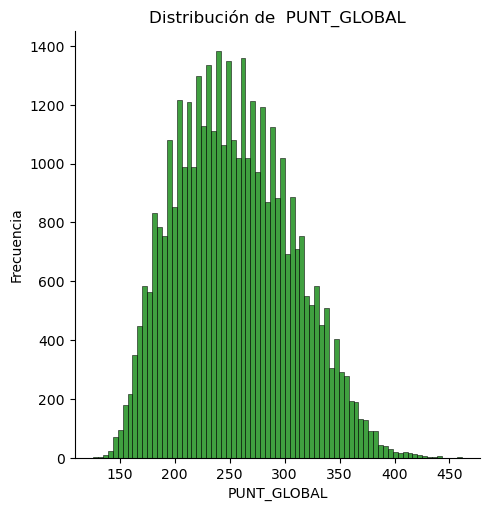

In [7]:
describir_var("PUNT_GLOBAL")

Estadísticas descriptivas para PERCENTIL_GLOBAL
--- --- --- --- 
count    39660.000000
mean        52.863137
std         28.675316
min          1.000000
25%         28.000000
50%         54.000000
75%         78.000000
max        100.000000
Name: PERCENTIL_GLOBAL, dtype: float64


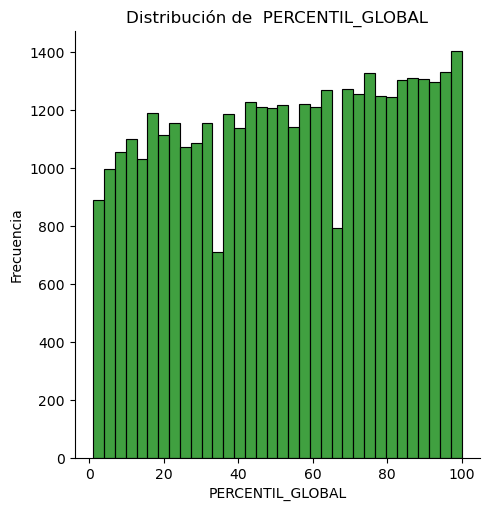

In [8]:
describir_var("PERCENTIL_GLOBAL")

Se observa que el puntaje global de los estudiantes tiene un comportamiento que aproxima una curva normal, con un leve sesgo a la izquierda. La curva está aproximadamente centrada en su promedio (254), y se observa que entre el valor mínimo (126) y el máximo (461) hay una distancia de aproximadamente 6.5 desviaciones estándar.

En cuanto al percentil, se aprecia una curva aproximadamente plana que asimila a una distribución uniforme. En concordancia con esta distribución, la media es aproximadamente la mitad del rango (52.9 vs. 50 teórico), y la desviación estándar es de 28.67 contra un valor teórico de 28.87. 

Para aplicaciones futuras, una posible aplicación de interés es realizar pruebas de bondad de ajuste chi-cuadrado para encontrar la distribución de probabilidad que mejor ajusta los datos.

Estadísticas descriptivas para FAMI_ESTRATOVIVIENDA
--- --- --- --- 
Distribución de valores:
FAMI_ESTRATOVIVIENDA
Estrato 2    14989
Estrato 1    11657
Estrato 3     9144
Estrato 4     2512
Estrato 5      853
Estrato 6      505
Name: count, dtype: int64
Moda: Estrato 2


<Figure size 1200x1000 with 0 Axes>

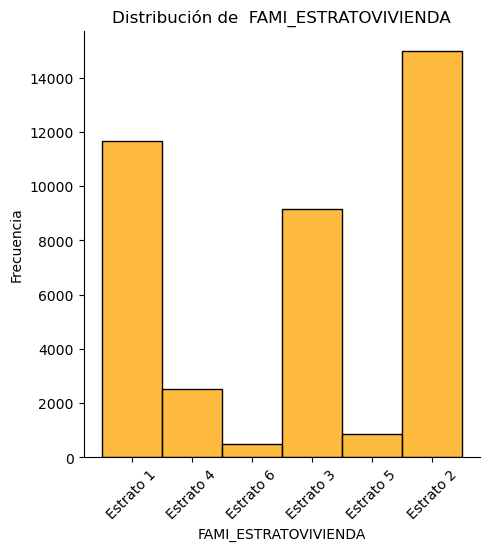

In [9]:
describir_var("FAMI_ESTRATOVIVIENDA")

Se observa que, en lo relacionado con estado económico familiar de los estudiantes, cerca al 67% reportan pertenecer a estratos bajos (1 y 2), y cerca del 3.4% de los estudiantes pertenecen a estratos altos (5 y 6). Estas cifras concuerdan de forma aproximada con censos realizados por el DANE para la frecuencia de familias por estrato en el país [1] , por lo que en este sentido puede afirmarse que la muestra aleatoria extraída es representativa de la población global.

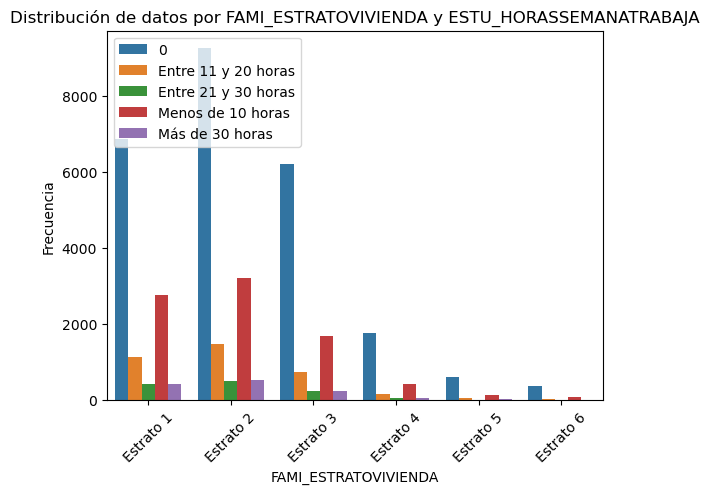

In [10]:
comparar_vars("FAMI_ESTRATOVIVIENDA", "ESTU_HORASSEMANATRABAJA")

Se observa que para todos los estratos la mayoría de estudiantes no trabajan. Ahora, ¿cómo se relaciona el estrato del estudiante con su desempeño en la prueba?

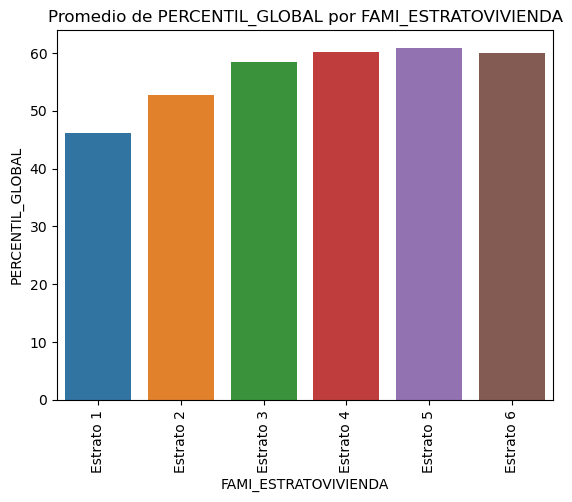

In [11]:
comparar_vars("FAMI_ESTRATOVIVIENDA", "PERCENTIL_GLOBAL")

Se observa que, en promedio, los estudiantes de estratos más altos tienen mejores puntajes en la prueba. ¿Cómo se relacionan estas dos variables, en interacción con el número de horas de trabajo?

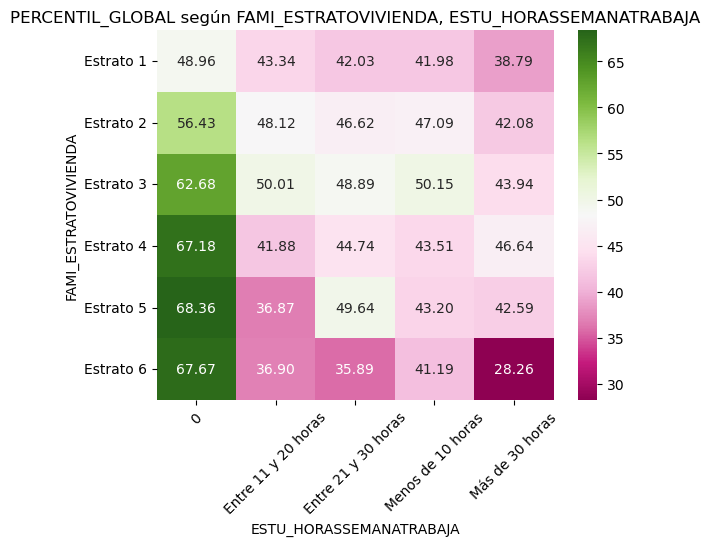

In [12]:
comparar_vars("FAMI_ESTRATOVIVIENDA", "PERCENTIL_GLOBAL", "ESTU_HORASSEMANATRABAJA")

En todos los estratos, se observa que los estudiantes que trabajan 0 horas a la semana tienen mejor puntaje que los que trabajan cualquier cantidad de tiempo. Se procede a explorar la relación entre más variables:

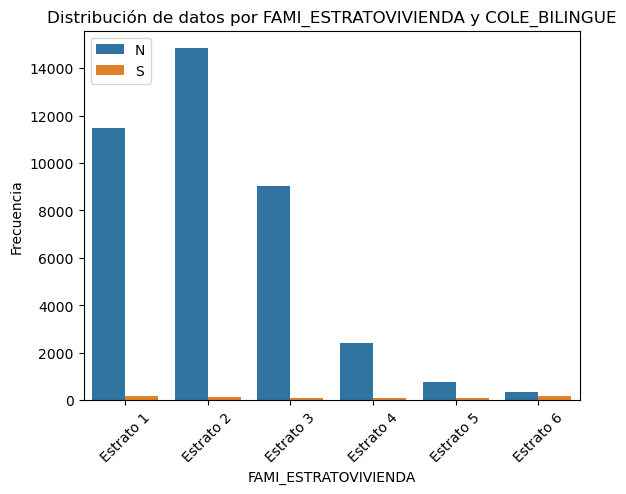

In [13]:
comparar_vars("FAMI_ESTRATOVIVIENDA", "COLE_BILINGUE")

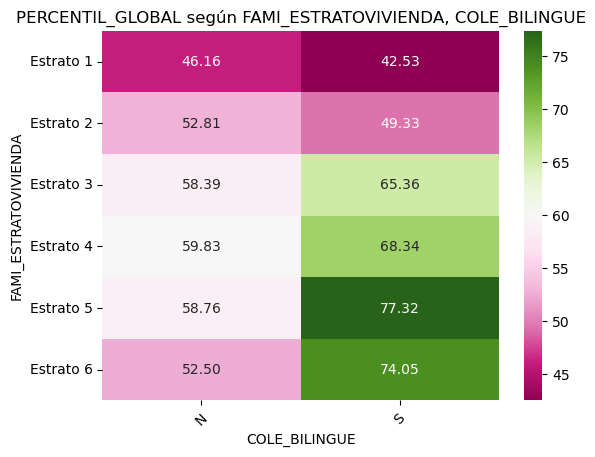

In [14]:
comparar_vars("FAMI_ESTRATOVIVIENDA", "PERCENTIL_GLOBAL", "COLE_BILINGUE")

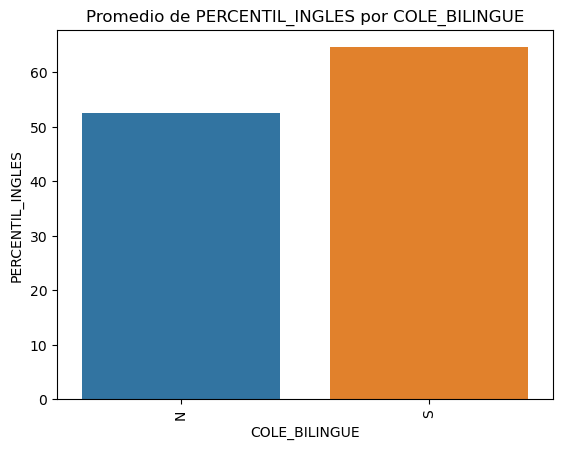

In [15]:
comparar_vars("COLE_BILINGUE", "PERCENTIL_INGLES")

Las anteriores gráficas muestran intuiciones muy importantes:
* Entre mayor es el estrato del estudiante, más probable es que su colegio sea bilingüe.
* A partir del estrato 3, los estudiantes de colegios bilingües tienen en promedio mejor puntaje en las pruebas, incluyendo la de inglés.
* Como el mejor puntaje en inglés está correlacionado con mejor puntaje en las demás áreas del conocimiento, es probable que los colegios bilingües preparen mejor a sus estudiantes para las pruebas en todas sus facetas. 

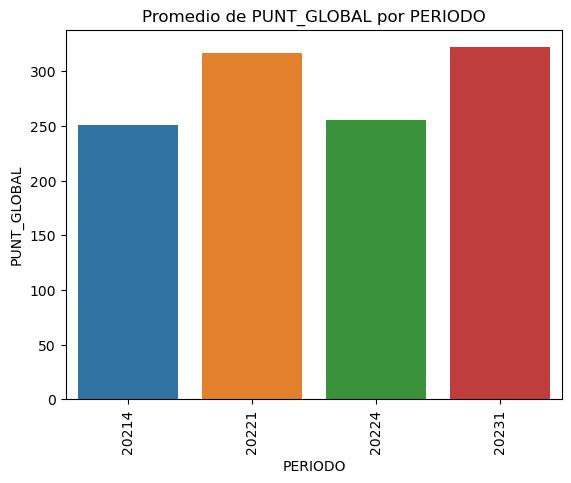

In [16]:
comparar_vars("PERIODO", "PUNT_GLOBAL")

Se observa que, según el periodo de presentación de la prueba, hay marcadas diferencias en el puntaje de los estudiantes. Esto puede tener múltiples causas, como por ejemplo que en un periodo la prueba haya sido mucho más difícil que en otro.

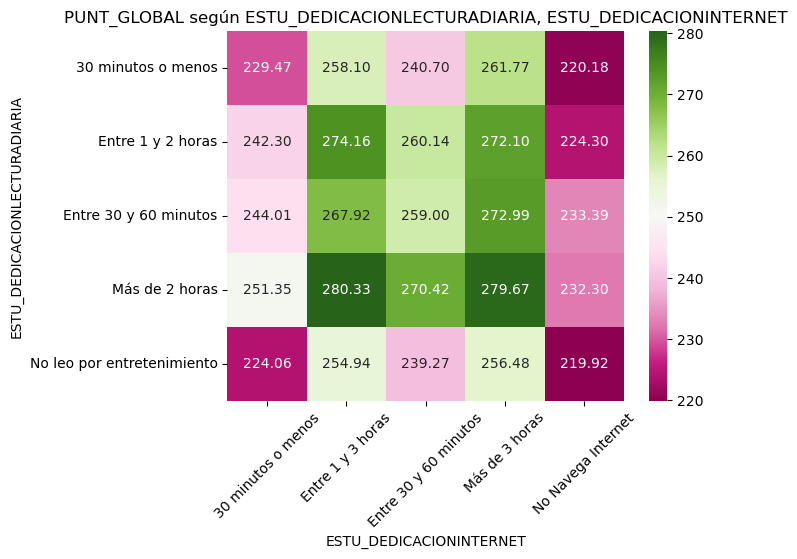

In [17]:
comparar_vars('ESTU_DEDICACIONLECTURADIARIA', "PUNT_GLOBAL","ESTU_DEDICACIONINTERNET" )

La gráfica anterior, en general indica que los estudiantes que más horas dedican a la lectura obtienen en promedio mejores resultados en las pruebas, al igual que los estudiantes que más tiempo dedican al internet. Esta última relación, sin embargo, puede ser simplemente un reflejo del estado económico de la familia del estudiante, ya que los estratos más bajos posiblemente no tengan acceso a internet.

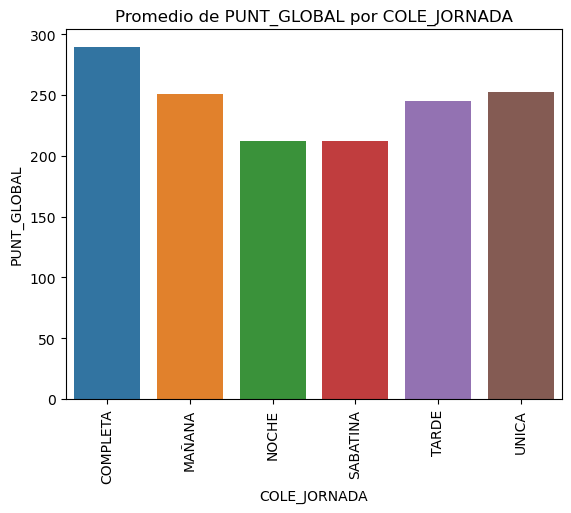

In [18]:
comparar_vars("COLE_JORNADA", "PUNT_GLOBAL")

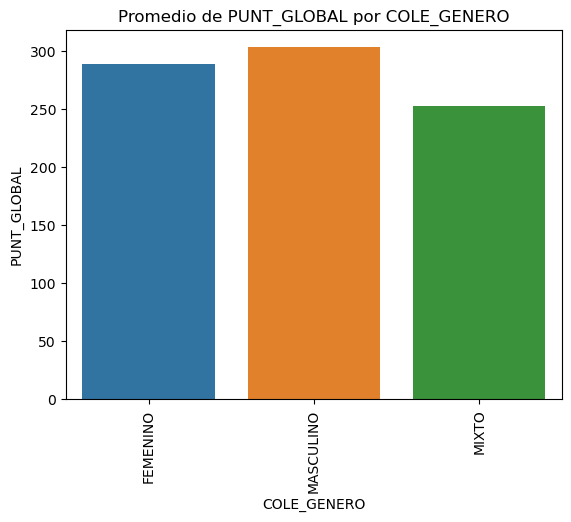

In [19]:
comparar_vars("COLE_GENERO", "PUNT_GLOBAL")

De la gráfica anterior, es interesante observar que los colegios mixtos tienen en promedio peor rendimiento que los colegios segregados por género.

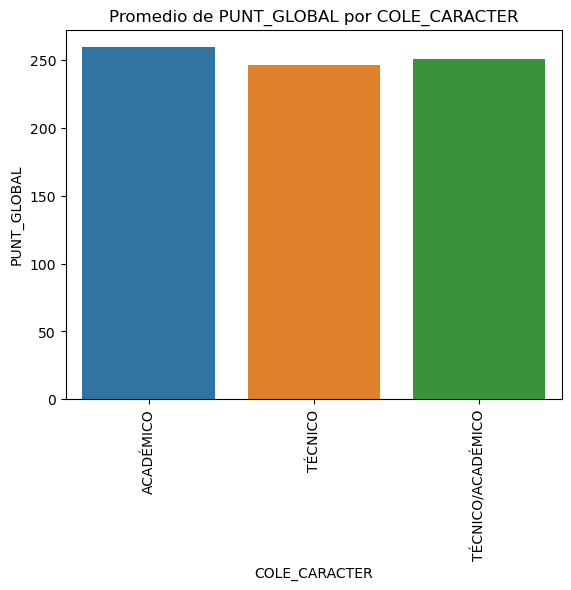

In [20]:
comparar_vars("COLE_CARACTER", "PUNT_GLOBAL")

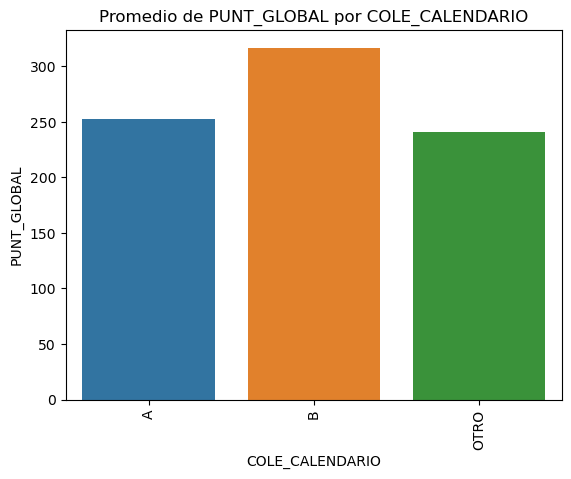

In [21]:
comparar_vars("COLE_CALENDARIO", "PUNT_GLOBAL")

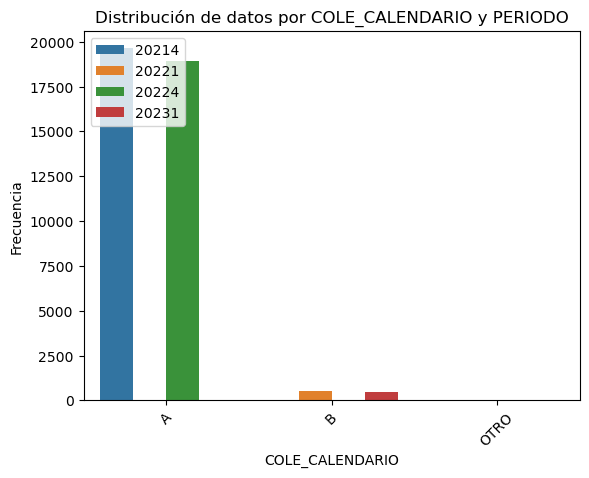

In [22]:
comparar_vars("COLE_CALENDARIO", "PERIODO")

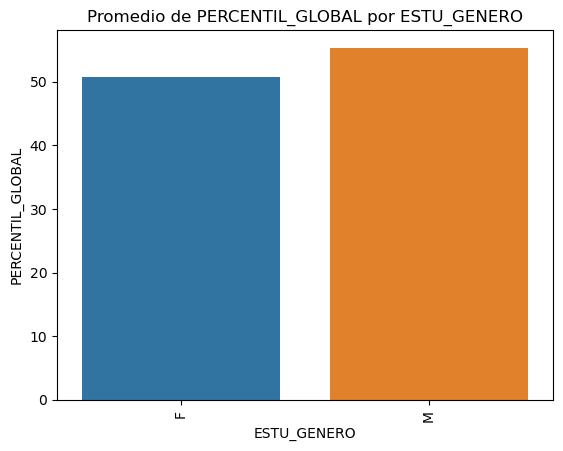

In [23]:
comparar_vars("ESTU_GENERO", "PERCENTIL_GLOBAL")

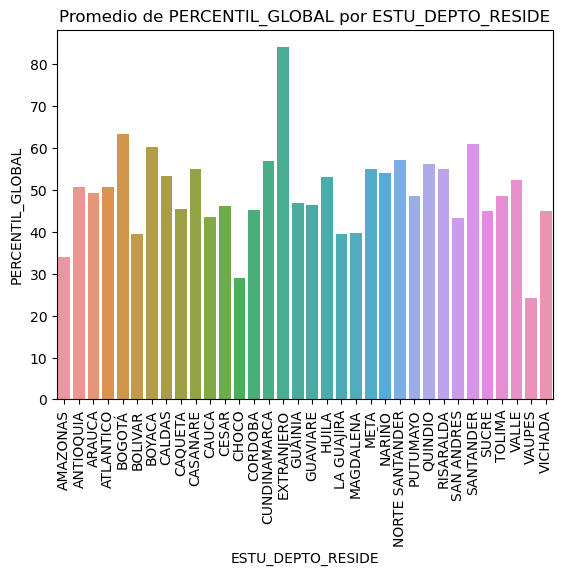

In [25]:
comparar_vars("ESTU_DEPTO_RESIDE", "PERCENTIL_GLOBAL")

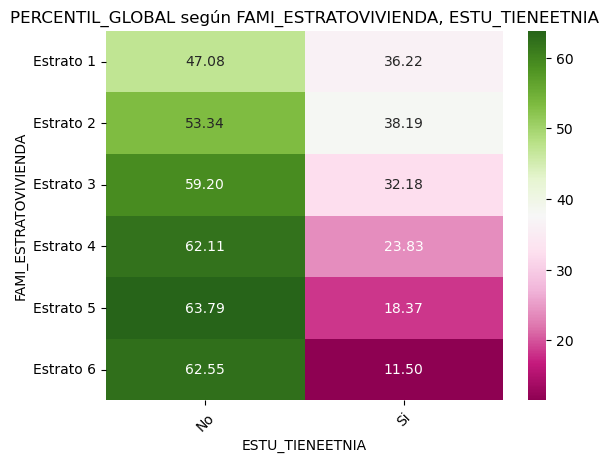

In [26]:
comparar_vars("FAMI_ESTRATOVIVIENDA", "PERCENTIL_GLOBAL", "ESTU_TIENEETNIA")

De las anteriores gráficas, se observan leves diferencias en el desempeño de los estudiantes según género, con los estudiantes de género masculino teniendo en promedio rendimientos levemente mejores. También, los estudiantes que reportan pertenecer a una etnia tienen en promedio puntajes mucho menores que los estudiantes que no, para todos los estratos.

Respecto al departamento de residencia, es notable la diferencia en puntaje de los estudiantes de Cundinamarca respecto a los demás departamentos. incluyendo la capital del país, Bogotá, la cual ocupa el segundo lugar. En general, los departamentos con más ciudades grandes tienen mejores percentiles. Esto va en concordancia con lo hallado acerca del estrato, pues es entendible que los estudiantes que habitan en centros urbanos tengan acceso a más recursos que aquellos en zonas rurales, entre ellos una educación de mejor calidad.


Para resumir la fase de análisis preliminar, se obtuvieron los siguientes hallazgos principales:
* Los estudiantes de mayores estratos tuvieron en promedio mejor rendimiento en las pruebas.
* Los estudiantes que no tenían obligaciones de trabajo, que dedicaban tiempo a leer y a la navegación por internet (por separado, no juntas) obtuvieron en promedio mejor rendimiento en las pruebas.
* En general, los estudiantes pertenecientes a colegios bilingües, de jornada completa, segregados por género, bilingües, de carácter académico (no técnico) y de calendario B son más probables de tener mejor desempeño en las pruebas. A su vez, los estudiantes de estratos más altos fueron más probables de pertenecer a los colegios bilingües que los demás estudiantes.
* Los estudiantes de género masculino tuvieron un rendimiento levemente mayor en las pruebas que los estudiantes de género femenino.

<a id="p4"></a>
## 4. Análisis de selección de modelos de _machine learning_

--- --- --- --- ---

In [1]:
# librerías fase 3
# librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# librerías para modelos
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression
from statsmodels.stats.diagnostic import het_white
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [8]:
# descargar datos fase 1 (opcional)
df=pd.read_csv("datos.csv")

Para abordar esta parte del problema, se buscará emplear en primera instancia un modelo para predecir`PERCENTIL_GLOBAL`, priorizando la interpretabilidad del modelo sobre capacidad predictiva. En este orden de ideas, se considera regresión lineal múltiple y posiblemente regresión logística (con la variable binarizada). 

Se procede a, en primer lugar, eliminar de consideración del modelo las variables secundarias sobre puntaje, para que el desempeño en la prueba no se prediga a sí mismo en los modelos. Se ignora también el departamento de residencia del estudiante, para concentrar el análisis en el efecto de variables limitadas sobre el puntaje en la prueba.

In [9]:
# eliminar las variables no útiles (el dataset original se copia antes de ser modificado)
# esta función debe cargarse de la fase 1
df_original=df.copy()
subgrupos("PUNT")
guardar_variables(df,[])

En total hay 6 columnas que comienzan por la clave: PUNT
A continuación se muestran según su índice:
--- --- --- --- 
0 : PUNT_LECTURA_CRITICA
1 : PUNT_MATEMATICAS
2 : PUNT_C_NATURALES
3 : PUNT_SOCIALES_CIUDADANAS
4 : PUNT_INGLES
5 : PUNT_GLOBAL
Se eliminaron en total 6 columnas.


In [10]:
subgrupos("PERCENTIL")
guardar_variables(df, ["PERCENTIL_GLOBAL"])

En total hay 6 columnas que comienzan por la clave: PERCENTIL
A continuación se muestran según su índice:
--- --- --- --- 
0 : PERCENTIL_LECTURA_CRITICA
1 : PERCENTIL_MATEMATICAS
2 : PERCENTIL_C_NATURALES
3 : PERCENTIL_SOCIALES_CIUDADANAS
4 : PERCENTIL_INGLES
5 : PERCENTIL_GLOBAL
Se eliminaron en total 5 columnas.


In [8]:
df.drop(["ESTU_DEPTO_RESIDE"], axis=1, inplace=True)

Tras las adecuaciones iniciales, se tienen 12 variables predictoras para `PERCENTIL_GLOBAL`.

In [2]:
# opcional: guardar en un .csv la base de datos para el modelo
# df.to_csv("datos_mod.csv", index=False)

# descargar datos fase 1 (opcional)
# df=pd.read_csv("datos_mod.csv")

Previo a la aplicación de modelos, la exploración preliminar de los datos da indicios de que es conveniente realizar ciertas transformaciones a los datos antes de continuar. Se destaca:
* Hay marcadas diferencias entre los promedios de pruebas entre primer y segundo semestre, pero no entre años. Por esta razón, es preferible cambiar `PERIODO` por su equivalente indicativo del semestre.
* Debe existir cierta correlación entre el género del estudiante y el género del colegio. Por ejemplo, un estudiante masculino no puede pertenecer a un colegio femenino, y viceversa. Para reducir la correlación entre estas variables, se transforma `COLE_GENERO` por una columna indicativa de si el colegio es mixto o no.
* Adicionalmente, debe también existir una correlación entre el semestre en que se presenta la prueba y el calendario del colegio. Como en la exploración preliminar de datos se encontró que casi para todos los casos los estudiantes de calendario B presentan la prueba el primer semestre y los de calendario A en el segundo, se remueve la variable `COLE_CALENDARIO`. 
* Por último, se renombran algunas columnas para mejorar su comprensión.

In [3]:
# eliminar COLE_CALENDARIO
df.drop(["COLE_CALENDARIO"], axis=1, inplace=True)
# transformar PERIODO por SEMESTRE

valores_periodo={20231: "Primero",
                 20224: "Segundo",
                 20221:"Primero",
                 20214:"Segundo"}
df['SEMESTRE'] = df['PERIODO'].map(valores_periodo)
df.drop(["PERIODO"], axis=1, inplace=True)

# COLE_GENERO: se reemplaza para determinar si es mixto o no
valores_col={'MIXTO': "Si",
         'MASCULINO': "No",
         'FEMENINO': "No"}
df["COLE_MIXTO"]=df["COLE_GENERO"].map(valores_col)
df.drop(["COLE_GENERO"], axis=1, inplace=True)

In [4]:
# renombrar columnas
df.rename(columns={"FAMI_ESTRATOVIVIENDA": "ESTRATO"}, inplace=True)
df.rename(columns={"ESTU_DEDICACIONLECTURADIARIA": "LECTURA_DIARIA"}, inplace=True)
df.rename(columns={'ESTU_DEDICACIONINTERNET': "INTERNET_DIARIO"}, inplace=True)
df.rename(columns={'ESTU_HORASSEMANATRABAJA': "TRABAJO_SEMANAL"}, inplace=True)

### Regresión Lineal Múltiple

Un modelo de `rlm` sólamente permite variables predictoras numéricas, por lo cual es necesario aplicar encoding a los datos. Sin embargo, esta opción debe usarse con precaución, pues agregar demasiadas variables _dummies_ al modelo crea multicolinearidad entre las variables (los niveles claramente están relacionados entre sí), y adicionalmente reduce su interpretabilidad al aumentar el número de variables en el modelo. Buscando un compromiso adecuado para el empleo del modelo, se toman las siguientes medidas:

* Aplicar una conversión numérica a las variables indicativas de la dedicación de tiempo del estudiante (lectura, internet, trabajo). Por ejemplo, si un estudiante dedica entre 30 y 60 minutos diarios a la lectura, se convertirá este valor a 0.75 horas de lectura diaria en promedio (45 minutos).
* Aplicar conversión numérica a `ESTRATO`. Esta transformación es razonable, pues los niveles de esta variable tienen un ordenamiento intrínseco.
* Aplicar encoding a las variables binarias (de dos niveles).
* En cuanto a las variables multiclase, como `COLE_CARACTER`, se va a aplicar el encoding sólamente para el nivel que en la exploración preliminar de datos mostró tener la mayor diferencia respecto a los demás grupos. Para el caso de la variable presentada, se tomaría encoding solamente para la jornada completa. 

Como cada variable tiene requerimientos diferentes, no es conveniente definir una función común para todos los cambios.

In [5]:
df_rlm=df.copy() #guardar una copia de los datos, para este modelo 

# lectura
# convertir variables de dedicación de tiempo
mapeo_lectura={'No leo por entretenimiento': 0,
               '30 minutos o menos': 0.25,
               'Entre 30 y 60 minutos': 0.75,
               'Entre 1 y 2 horas': 1.5,
               'Más de 2 horas':2.5 }
# reemplazar la columna por el nuevo mapeo
df_rlm.replace({'LECTURA_DIARIA': mapeo_lectura}, inplace=True)

#internet
mapeo_internet={'No Navega Internet': 0,
                '30 minutos o menos': 0.25,
                'Entre 30 y 60 minutos': 0.75,
                'Entre 1 y 3 horas':2, 
                'Más de 3 horas': 3.5}
df_rlm.replace({'INTERNET_DIARIO': mapeo_internet}, inplace=True)

# trabajo, se aprovecha para convertir a dedicación diaria (mismas unidades que las demás variables)
mapeo_trabajo={'0':0, 
               'Menos de 10 horas': 5/7, # se asume promedio de 5 horas a la semana, 5/7 horas diarias
               'Entre 11 y 20 horas': 15/7,
               'Entre 21 y 30 horas': 25/7, 
                'Más de 30 horas': 35/7}
# renombrar columna para mostrar nuevas unidades
df_rlm.rename(columns={"TRABAJO_SEMANAL": "TRABAJO_DIARIO"}, inplace=True)
df_rlm.replace({'TRABAJO_DIARIO': mapeo_trabajo}, inplace=True)

# estrato
mapeo_estrato={'Estrato 1': 1,
               'Estrato 2': 2,
               'Estrato 3': 3,
               'Estrato 4': 4,
               'Estrato 5':5,
               'Estrato 6':6}
df_rlm.replace({'ESTRATO': mapeo_estrato}, inplace=True)

In [6]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

# dummies para variables binarias: ESTU_GENERO, ESTU_TIENEETNIA, COLE_BILINGUE
df_rlm = pd.get_dummies(df_rlm, columns=["ESTU_GENERO"], drop_first=True, prefix="GENERO") #eliminar columna original
df_rlm = pd.get_dummies(df_rlm, columns=["ESTU_TIENEETNIA"], drop_first=True, prefix="ETNIA") #eliminar columna original
df_rlm = pd.get_dummies(df_rlm, columns=["COLE_BILINGUE"], drop_first=True, prefix="BILINGUE")


In [7]:
# dummies limitadas para variables multiclase: COLE_CARACTER, COLE_JORNADA
# se usa encoding sólo para el nivel más destacado (ver exploración preliminar)
df_rlm["COLE_ACADEMICO"] = np.where(df_rlm["COLE_CARACTER"] == 'ACADÉMICO', 1, 0)
df_rlm["JORNADA_COMPLETA"] = np.where(df_rlm["COLE_JORNADA"] == 'COMPLETA', 1, 0)
#eliminar columnas obsoletas
df_rlm.drop(["COLE_CARACTER", "COLE_JORNADA"], axis=1, inplace=True)

In [8]:
# mapeo para SEMESTRE y COLE_MIXTO
mapeo_sem={'Primero': 1,
           'Segundo': 0}
df_rlm.rename(columns={"SEMESTRE": "PRIMER_SEMESTRE"}, inplace=True)
df_rlm.replace({'PRIMER_SEMESTRE': mapeo_sem}, inplace=True)

mapeo_col={'Si': 1,
           'No': 0}
df_rlm.replace({'COLE_MIXTO': mapeo_col}, inplace=True)

# mapear todas las columnas como numéricas
cols=["GENERO_M", "ETNIA_Si", "BILINGUE_S"]
for i in cols:
    df_rlm[i]=df_rlm[i].astype(int)

Tras las transformaciones y encoding realizados, se cuenta con la siguiente estructura de datos:

In [9]:
df_rlm.dtypes

ESTRATO               int64
LECTURA_DIARIA      float64
INTERNET_DIARIO     float64
TRABAJO_DIARIO      float64
PERCENTIL_GLOBAL    float64
PRIMER_SEMESTRE       int64
COLE_MIXTO            int64
GENERO_M              int32
ETNIA_Si              int32
BILINGUE_S            int32
COLE_ACADEMICO        int32
JORNADA_COMPLETA      int32
dtype: object

Posterior a la transformación de variables, deben verificarse para los datos la validez de los supuestos en los que se basa la regresión lineal múltiple. Estos incluyen [2]:

* La relación entre la variable dependiente y las variables predictoras es lineal

Como las variables predictoras no son numéricas continuas, es difícil verificar esta propiedad mediante gráficos de dispersión que muestren una clara tendencia lineal. De las gráficas por pares que se ven a continuación, no es posible confirmar ni rechazar este supuesto.

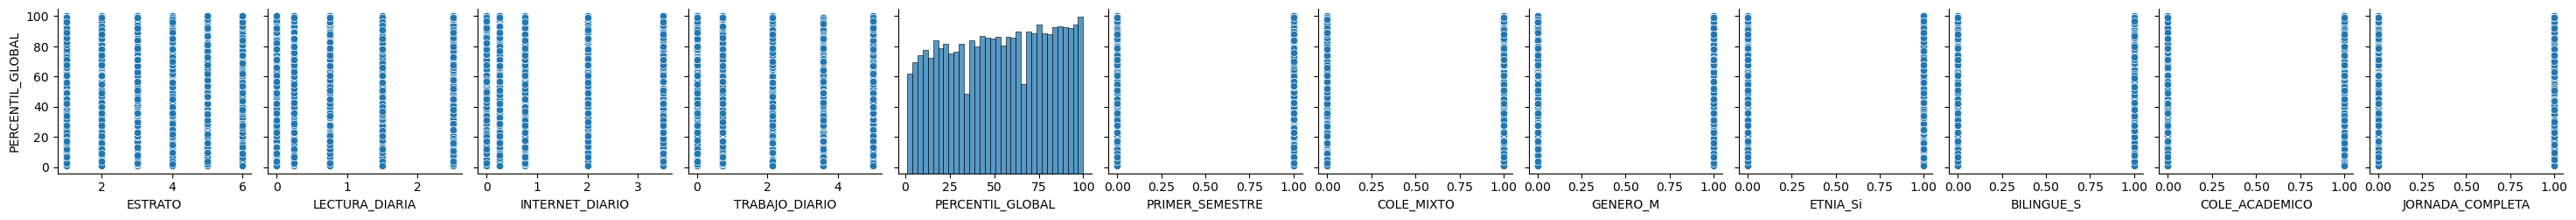

In [19]:
sns.pairplot(df_rlm, y_vars="PERCENTIL_GLOBAL")

* Independencia entre las observaciones

Este supuesto puede responderse considerando las condiciones en que se recolectaron los datos. La prueba toma lugar el mismo día para todos los estudiantes que la presentan, un docente vigila que no haya comunicación entre los estudiantes durante el examen, y esta se actualiza con nuevas preguntas cada edición, por lo cual no hay razón para que las observaciones no sean independientes entre sí.

* Homoscedasticidad en el error

Este supuesto puede verificarse mediante la prueba de White, la cual realiza una prueba estadística cuya hipótesis nula es homoscedasticidad, es decir igual varianza del error de la regresión [3]. El supuesto se verifica con un modelo ya ajustado.


In [20]:
# parte 1: realizar la partición de los datos en prueba y test (X_total ya se definió)
y_total=df_rlm["PERCENTIL_GLOBAL"] #separar a y
# separar las variables predictoras de la objetivo
X_total=df_rlm.copy()
X_total.drop(["PERCENTIL_GLOBAL"], axis=1, inplace=True)
y_total=df_rlm["PERCENTIL_GLOBAL"]

XTrain, XTest, yTrain, yTest = train_test_split(X_total, y_total, test_size=0.2, random_state=0)

# adaptado de https://www.statology.org/white-test-in-python/
#add constant to predictor variables
XTrain_1 = sm.add_constant(XTrain)

#fit regression model
model = sm.OLS(yTrain, XTrain_1).fit()
#perform White's test
white_test = het_white(model.resid,  model.model.exog)

#define labels to use for output of White's test
labels = ['Estadístico de prueba: ', 'p-value: ', 'Estadístico F', 'p-value Prueba F']

#print results of White's test
#print(zip(labels, white_test))
for i in range(0, len(labels)):
    print(labels[i]+": "+str(white_test[i]))


Estadístico de prueba: : 814.507823636008
p-value: : 2.721969725872871e-127
Estadístico F: 11.915682098446227
p-value Prueba F: 3.223228595021048e-129


Se observa que, con una probabilidad muy pequeña de error, hay heteroscedasticidad en los datos. Es decir, la varianza del error no es constante, lo cual viola los supuestos de la regresión lineal. La heteroscedasticidad tiene múltiples posibles soluciones, dependiendo de la naturaleza de los datos (la cual es difícil de juzgar por la alta dimensionalidad presente). Para la aplicación actual, se va a buscar solucionar el problema empleando un modelo de regresión lineal regularizado con penalización tipo _Lasso_. Este modelo es robusto a la influencia de valores atípicos (que pueden estar causando el problema), lo cual puede corregir el problema observado, y no reduce en gran medida la interpretabilidad del modelo.


* Independencia entre las variables predictoras (el opuesto es la multicolinearidad)

Para verificar este supuesto, se emplea una matriz de correlación de Pearson por pares. La correlación de Pearson mide, de -1 a 1, la fuerza de la relación lineal entre dos variables.

[Text(0.5, 1.0, 'Matriz de Correlación por pares')]

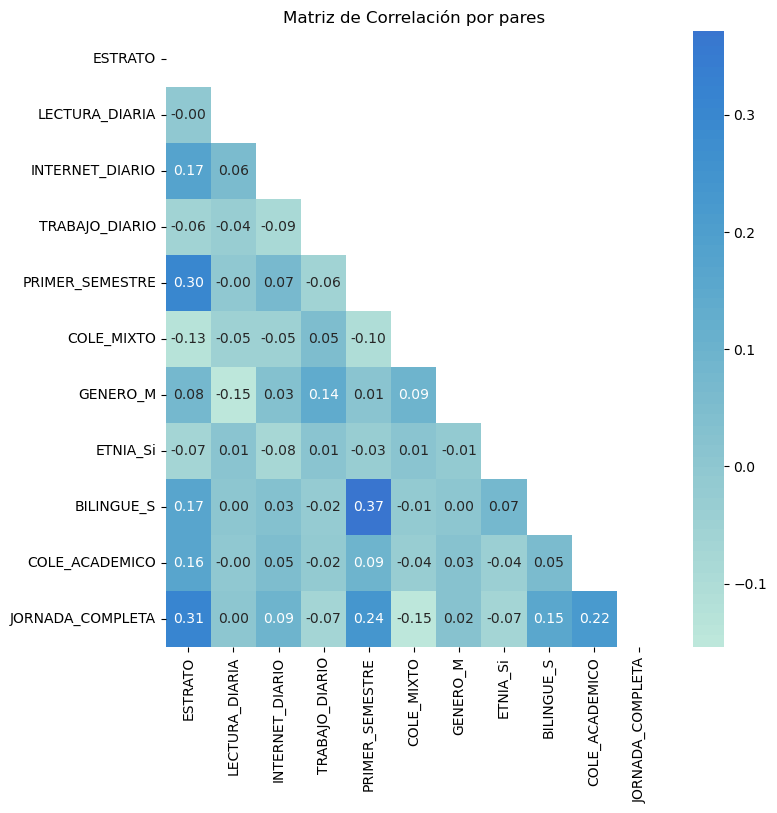

In [21]:
# Adaptado de
# https://stackoverflow.com/questions/57414771/how-to-plot-only-the-lower-triangle-of-a-seaborn-heatmap

cols=X_total.columns
plt.figure(figsize=(8, 8))
correlation_matrix = X_total.loc[:, cols].corr()
matrix = np.triu(correlation_matrix)

sns.heatmap(
    correlation_matrix,
    annot=True, 
    mask=matrix,
    center=1,
    fmt=".2f"
).set(title='Matriz de Correlación por pares')

De la matriz de correlaciones, se observa en primer lugar que no existen correlaciones de muy alta intensidad entre las variables, que necesiten un cambio adicional en los datos. En segundo lugar, se observan relaciones interesantes en los datos que no fueron detectadas en el análisis preliminar de datos. Por ejemplo, para colegios de calendario B, es más probable que los estudiantes pertenezcan a estratos más altos, bilingües y de jornada completa. 

Antes de ajustar un modelo de regresión lineal, es prudente realizar selección de variables, o _feature selection_ mediante filtros. Este proceso involucra realizar pruebas estadísticas sobre las variables predictoras para verificar que sean lo suficientemente explicativas de la variable objetivo. Se emplea un estadístico de prueba $F$ para cada variable individual.

Sobre los métodos de filtrado, estos son computacionalmente más eficientes que los métodos de envoltura, pero involucran cierta subjetividad, ya que depende del analista definir el límite de significancia. El límite de significancia de una variable varía según los grados de libertad que tenga, así como del número total de observaciones, pero por lo general un valor de 50 para el estadístico de prueba es suficiente para significancia estadística.

Variables seleccionadas: 11 / 11


Text(0, 0.5, 'F scores')

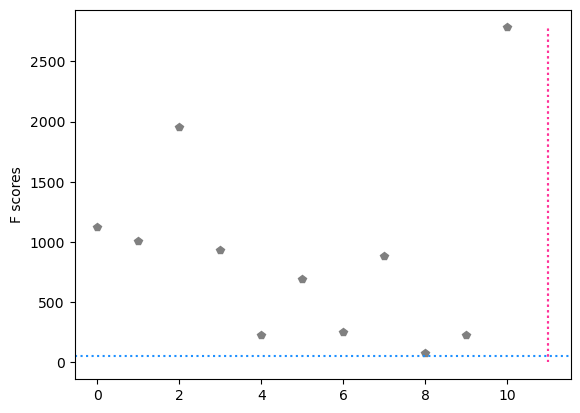

In [22]:
fscore_threshold: int = 50 # threshold prueba F para selección de 10 variables
ftest = f_regression(X_total.to_numpy(), y_total.to_numpy().ravel())
qfeatures = X_total.shape[1]

print('Variables seleccionadas:', (ftest[0]>fscore_threshold).sum(), '/', qfeatures)
X_total.columns[ftest[0]>fscore_threshold] # Conjunto de variables seleccionadas
plt.plot(ftest[0],'p',color='gray')
plt.vlines(x=[X_total.shape[1], qfeatures],ymin=-2,ymax=np.max(ftest[0])+5,ls=':',colors='#ff3399')
plt.axhline(y=fscore_threshold,ls=':',color='dodgerblue') 
plt.ylabel('F scores')

Se observa que, según el razonamiento expuesto previamente, todas las variables predictivas presentadas son lo suficientemente explicativas como para ser incluidas en el modelo. Se procede finalmente con la creación del modelo de _Lasso_, usando adicionalmente validación cruzada, la cual realiza alterna la muestra de test entre los datos para dar un resultado más confiable del MSE.

In [23]:

# lasso necesita un parámetro de calibración, alpha
# alpha determina qué tanto se penaliza los términos de alto error
n_alphas = 200
alphasCalibrar = np.logspace(-10, 2, n_alphas)
modeloLASSO = LassoCV(alphas=alphasCalibrar).fit(XTrain, yTrain)
print('El parámetro de penalización es:')
print(modeloLASSO.alpha_)
print('El valor del R^2 es:')
print(modeloLASSO.score(XTrain, yTrain))

# imprimir los coeficientes
cols=list(X_total.columns)
coefficient_pairs = zip(cols, modeloLASSO.coef_)
for name, coef in coefficient_pairs:
  print(f"{name}: {coef:.4f}")  # 4 decimales de precisión para cada coeficiente



El parámetro de penalización es:
0.0026126752255633263
El valor del R^2 es:
0.1721372489429388
ESTRATO: 1.1864
LECTURA_DIARIA: 7.2814
INTERNET_DIARIO: 3.6816
TRABAJO_DIARIO: -3.0960
PRIMER_SEMESTRE: -3.8106
COLE_MIXTO: -12.0422
GENERO_M: 6.7470
ETNIA_Si: -15.0766
BILINGUE_S: 2.3800
COLE_ACADEMICO: 0.2337
JORNADA_COMPLETA: 15.1443


Los resultados obtenidos muestran que el modelo de regresión lineal múltiple tiene muy poco poder predictivo para la variable objetivo, `PERCENTIL_GLOBAL`, y solamente puede explicar el 17% de su variabilidad. 
Con base a estos resultados, es muy posible que el problema de heteroscedasticidad no haya sido solucionado mediante el modelo de regresión penalizado. Para el alcance de este trabajo, sin embargo, no se buscarán más alternativas al problema, sino que se intentará abordar desde una perspectiva de clasificación, con modelos robustos a la entrada de variables categóricas. No es conveniente realizar afirmaciones sobre la influencia de las variables predictivas en el modelo, pues no se consiguió un buen modelo.

Por último, por la presencia de heteroscedasticidad se descarta el uso de regresión logística.

### Árboles de Decisión

Los árboles de decisión son un tipo de modelo que permite como entrada variables categóricas y es robusto a la entrada de variables no informativas al modelo. En esencia, busca crear particiones secuenciales en el espacio de X, similar a las ramas en un árbol, buscando obtener en sus hojas finales la mayor pureza posible enytre clases.


Una desventaja de los árboles de decisión es que por lo general un sólo árbol tiene un desempeño predictivo pobre sobre un conjunto de datos, por lo cual se usan métodos de ensamblaje que combinen diferentes árboles para crear un modelo general de mejor desempeño. Para esta aplicación se empleará _Random Forest_, un tipo de modelo de ensamblaje con árboles de decisión que en cada _split_ o nodo del árbol elige de forma aleatoria una de las variables predictivas para la siguiente partición secuencial.

Buscando mejorar la capacidad predictiva del modelo, se va a convertir el problema en uno de clasificación binario. Se busca un modelo que pueda separar a los estudiantes que obtienen puntajes superiores al percentil 75, de los que no. Con el diseño de esta variable objetivo, se espera identificar qué variables influencian más a los estudiantes con mejores resultados de los demás. Al poner un límite inferior que no es tan alto (75), se evita generar problemas adicionales de clases desbalanceadas.

Por último, aunque en teoría los árboles de decisión reciben variables predictivas categóricas, se emplean las numéricas desarrolladas para el modelo anterior, debido a que los métodos de la librería empleada, `sklearn`, no reciben variables categóricas.

In [10]:
# usar una prueba lógica, si la observación está por encima o por abajo del promedio
# se recicla el dataset del modelo de regresión lineal
df_rlm["CUARTIL_SUPERIOR"] = df_rlm["PERCENTIL_GLOBAL"] > 75.0
df_rlm["CUARTIL_SUPERIOR"]=df_rlm["CUARTIL_SUPERIOR"].astype(int)
df_rlm.drop(["PERCENTIL_GLOBAL"], axis=1, inplace=True)

In [11]:
# verificar desbalanceo de clases
df_rlm["CUARTIL_SUPERIOR"].value_counts()

CUARTIL_SUPERIOR
0    28753
1    10907
Name: count, dtype: int64

In [20]:
# parte 1: dividir los datos en train y test (se reciclan variables del modelo anterior)
y_total=df_rlm["CUARTIL_SUPERIOR"]
X_total=df_rlm.copy()
X_total.drop(["CUARTIL_SUPERIOR"], axis=1, inplace=True)

XTrain, XTest, yTrain, yTest = train_test_split(X_total, y_total, test_size=0.2, random_state=0)

#parte 2: crear un objeto de clasificador random forest y entrenarlo
clfRF = RandomForestClassifier(random_state=0)
clfRF.fit(XTrain, yTrain)

#parte 3: predecir los nuevos puntos
y_hat_prob=clfRF.predict_proba(XTest)[:,0]
y_hat=clfRF.predict(XTest)

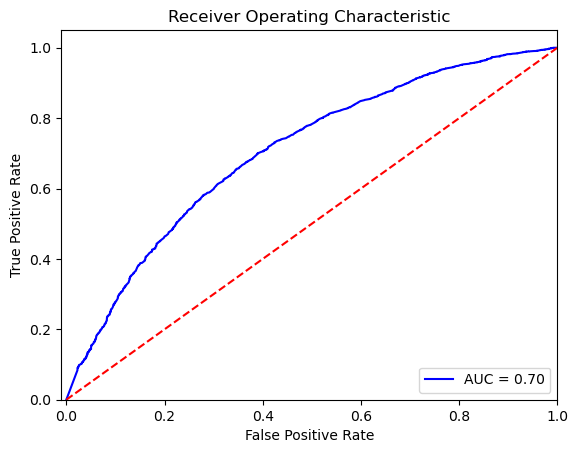

Accuracy: 0.7405
Precisión: 0.5705
Sensibilidad: 0.2665


In [23]:
# evaluar rendimiento del modelo
#parte 4: evaluar el rendimiento del modelo
fpr, tpr, thresholds = metrics.roc_curve(yTest, y_hat_prob, pos_label=0)
AUCRF=metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUCRF)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

accuracy = accuracy_score(yTest, y_hat)
precision = precision_score(yTest, y_hat) 
recall = recall_score(yTest, y_hat)  

print(f"Accuracy: {accuracy:.4f}")
print(f"Precisión: {precision:.4f}")
print(f"Sensibilidad: {recall:.4f}")

Se obtienen los siguientes resultados sobre el modelo _Random Forest_:
* El modelo clasifica correctamente si un estudiante pertenece o no al cuartil superior de puntajes el 74% de las veces (_accuracy_).
* El 57% de las predicciones de que un estudiante pertenecía a la clase positiva fueron correctas (precisión).

* El 26% de los casos reales de estudiantes en la clase positiva fueron identificados por el modelo.

El AUC (_Area Under the Curve_), en términos generales, esta métrica resume la capacidad del modelo para distinguir correctamente entre las clases positivas y negativas. Un AUC de 0.7 indica que, el 70% de las veces, el modelo distingue correctamente entre las dos clases de la variable objetivo, en este caso los estudiantes del cuartil superior de rendimiento en las pruebas.

Puede afirmarse que, en general, el modelo tiene un buen rendimiento para el conjunto de datos y logra diferenciar de forma satisfactoria las clases según sus variables predictivas. Ahora, podemos visualizar las variables que mayor importancia tienen en la creación del modelo, basado en la métrica del MDI (_Mean Decrease in Impurity_):

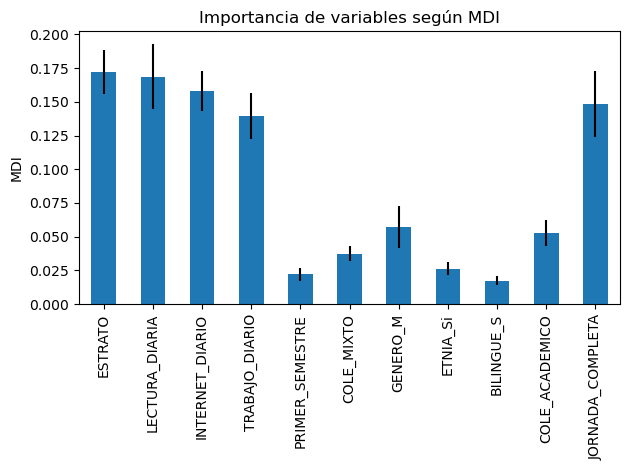

In [24]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
feature_names = list(X_total.columns)
importances = clfRF.feature_importances_
std = np.std([tree.feature_importances_ for tree in clfRF.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Importancia de variables según MDI")
ax.set_ylabel("MDI")
fig.tight_layout()


De lo anterior, se observa que las variables más influyentes dentro del conjunto de datos para determinar si un estudiante tiene un buen puntaje en la prueba son: 
* Su estrato (entre más alto, mejor)
* Su dedicación diaria a la lectura (entre más, mejor)
* Su dedicación diaria al internet (entre más, mejor)
* Si su colegio es de jornada completa (es preferible a que no lo sea)
* Su dedicación al trabajo (es preferible que no trabaje)

Las demás variables incluidas en el modelo mostraron tener poca importancia relativa. 

Es importante resltar que, aunque el desarrollo de modelos no fue exhaustivo, se logró identificar de forma correcta las variables que más efecto tienen para que un estudiante tenga un buen rendimiento en las pruebas Saber. También, es razonable que no se obtengan rendimientos muy altos para los modelos, pues las variables predictivas no son suficientes para captar la gran complejidad de variables que determinan en última instancia el desempeño de los estudiantes. Por ejemplo, tener información sobre pruebas de _IQ_ para cada estudiante sería probablemente una métrica de utilidad en modelos predictivos, pero en la realidad es imposible de conseguir a tan grande escala.

<a id="p5"></a>
## 5. Herramienta interactiva de visualización (_dashboard_)
--- ---

In [2]:
# de ser necesario correr en local: pip install jupyter_bokeh
import pandas as pd
import numpy as np
# librerías
import panel as pn
from bokeh.plotting import figure 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
pn.extension('plotly')

In [3]:
# (opcional)
df=pd.read_csv("datos.csv")

A continuación, se presenta una herramienta que permite al usuario:
* Elegir una variable objetivo (puntaje o percentil general o de una materia específica)
* Elegir una variable predictiva sobre el estado socioeconómico del estudiante (características de colegio, estrato, etc.)

Con estos valores de entrada, el usuario podrá visualizar:
* Un gráfico de barras para la distribución de valores según la calificación y materia escogidas.
* Un gráfico de pastel(_pie chart_) con la distribución de estudiantes por nivel de la variable.
* Un histograma con la distribución de la variable objetivo, su media, desviación estándar y demás estadísticas descriptivas.

### Nota: 
La herramienta se probó con éxito en varias instancias. Sin embargo, se observa que la imagen tiende a congelarse cuando se tiene muy ocupada la memoria _RAM_ del ordenador. Se recomienda correr el código de esta fase independiente de las demás, para que funcione correctamente.

In [4]:
# https://panel.holoviz.org/reference/widgets/Select.html
#  Primera parte: Definir botones de pre-selección de variables

# crear los menús de selección
materia = pn.widgets.Select(name="Escoja una materia",
    options={"General": 1, "Matemáticas":2, "Ciencias":3, 
             "Sociales":4, "Inglés":5, "Lectura Crítica":6})

calif=pn.widgets.RadioButtonGroup(name="Escoja una calificación",
    options={"Puntaje":1, "Percentil":2}, button_type='success')

# guardar los nombres de columnas de x

cols_x=['ESTU_GENERO', 'PERIODO', 'ESTU_TIENEETNIA', 'ESTU_DEPTO_RESIDE',
       'FAMI_ESTRATOVIVIENDA', 'ESTU_DEDICACIONLECTURADIARIA',
       'ESTU_DEDICACIONINTERNET', 'ESTU_HORASSEMANATRABAJA', 'COLE_GENERO',
       'COLE_CALENDARIO', 'COLE_BILINGUE', 'COLE_CARACTER', 'COLE_JORNADA']

x_1=pn.widgets.Select(name="Escoja una variable predictiva",
    options=cols_x)


In [5]:
# Segunda parte: agregar funcionalidad al tablero de control, definir las gráficas
# se crea una función por cada gráfica

# gráfica 1: gráfico de barras o de calor para puntaje o percentil según x1, x2
@pn.depends(materia.param.value, calif.param.value, x_1.param.value)
def grafica_1(materia, calif, x_1): 
    # filtrar el dataframe con concatenación de str, se definen diccionarios para búsqueda ágil
    dict_calif={1: "PUNT_", 2: "PERCENTIL_"}
    str_calif=dict_calif[calif]
    
    dict_materia={1: "GLOBAL", 2: "MATEMATICAS", 3: "C_NATURALES",
                  4: "SOCIALES_CIUDADANAS", 5:"INGLES", 6: "LECTURA_CRITICA"}
    str_materia=dict_materia[materia]
    
    y=str_calif+str_materia # la variable y
    
    # agrupar por categoría
    promedios = df.groupby(x_1)[y].mean()
    promedios.plot(kind='bar')
    # Graficar promedios mediante gráfico de barras
    fig = go.Figure(
    data=[go.Bar(
        name="Values",
        x=promedios.values,  
        y=promedios.index,                                
        marker_color='#EB89B5', 
        orientation="h" 
    )],
)
    fig.update_layout(
        title="Promedio "+y+ " por "+x_1,
        xaxis_title=y,
        yaxis_title=x_1,
        xaxis_showgrid=False,  # Hide gridlines on the x-axis (optional),
        width=800, 
        height=400
    )
    return fig  

In [6]:
# https://plotly.com/python/pie-charts/
# grafica 2: gráfico de pastel por variable predictiva
@pn.depends(x_1.param.value)
def grafica_2(x_1):
    # organizar el df
    cuentas = df[x_1].value_counts()
    #guardar el nombre y cuenta de cada valor, en el orden correcto
    niveles=[]
    porcentajes=[]
    for nivel, cuenta in cuentas.items():
        niveles.append(nivel)
        porcentaje = (cuenta / len(df)) * 100
        porcentajes.append(porcentaje)
        
    # definir el gráfico    
    fig = go.Figure(data=[go.Pie(labels=niveles, values=porcentajes)])
    fig.update_layout(
        title="Distribución de "+x_1,
        width=600,
        height=350
    )
    #fig.set_size_inches(12, 8)
    return fig  

In [7]:
# https://plotly.com/python/histograms/
# gráfica 3: histograma para la calificación y materia escogidas
@pn.depends(calif.param.value, materia.param.value)
def grafica_3(calif, materia):
    # filtrar el dataframe con concatenación de str, se definen diccionarios para búsqueda ágil
    dict_calif={1: "PUNT_", 2: "PERCENTIL_"}
    str_calif=dict_calif[calif]
    
    dict_materia={1: "GLOBAL", 2: "MATEMATICAS", 3: "C_NATURALES",
                  4: "SOCIALES_CIUDADANAS", 5:"INGLES", 6: "LECTURA_CRITICA"}
    str_materia=dict_materia[materia]
    
    y=str_calif+str_materia # la variable y
    
    #graficar histograma
    fig = go.Figure()
    fig.add_trace(go.Histogram(
    x=df[y],
    marker_color='#90EE90',
    opacity=0.75
))
    fig.update_layout(
        title="Distribución de "+y,
        xaxis_title=y,
        yaxis_title="Frecuencia",
        width=700
    )
    
    return fig
    

Launching server at http://localhost:54636


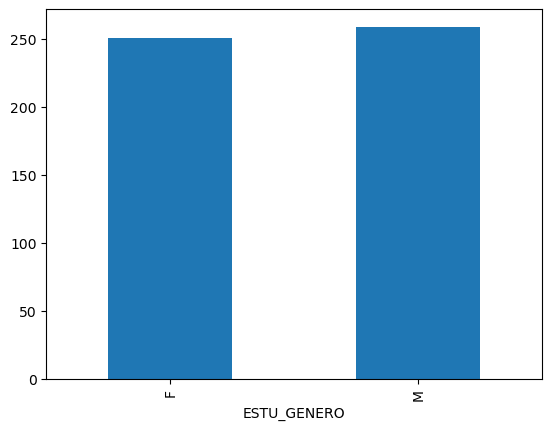

In [8]:
# parte 3- declarar tablero de control y presentar dashboard

# falta ubicar grafica 2 en la parte inferior
titulo = "# Tablero interactivo ICFES Data 2021-2 a 2023-1"
row1 = pn.Column(
    pn.WidgetBox(titulo, calif, materia, x_1), grafica_3)
row2=pn.Column(grafica_1, grafica_2)


tablero = pn.Row(row1, row2)
tablero.show()

<a id="p6"></a>
## 6. Conclusiones
--- ---



En conclusión, el presente estudio logró con éxito identificar variables de influencia para predecir el rendimiento académico de un estudiante en las pruebas Saber 11 en Colombia. Desde luego, el estado socioeconómico de la familia del estudiante juega un rol importante, y no puede negarse que los estudiantes de familias con más medios económicos tienen más oportunidades de mejor educación que los demás estudiantes.

Sin embargo, el estudio también muestra que no toda la variabilidad del problema puede ser explicada por condiciones externas al estudiante, como lo es el estado económico. Se encontró que, entre otras cosas, aquellos estudiantes que más tiempo leen tienden a tener mejor puntaje en las pruebas. Lo mismo con el colegio del estudiante, independientemente del estrato, aquellos colegios de jornada completa y de carácter académico también mostraron ser influyentes en preparar mejor a los estudiantes para las pruebas. 

Los hallazgos encontrados sobre los colegios y las buenas prácticas de uso del tiempo pueden ser un buen punto de partida para padres de familia o agentes gubernamentales que se interesen por mejorar el estado de la educación de sus hijos o de los jóvenes de Colombia, y lograr que la educación lleve al progreso de la sociedad como un todo.

<a id="p7"></a>
## 7. Referencias
--- ---

[1] DANE, "Estudios Poscensales de jóvenes investigadores- La Heterogeneidad de los estratos". 2022, disponible en línea en https://www.dane.gov.co/files/censo2018/estudios-poscensales/08-heterogeneidad-de-los-estratos.pdf

[2] R. Walpole, R. Myers y S. Myers, "Probabilidad y estadística para ingeniería y ciencias", novena edición, 2012, Pearson. 

[3] Test de White. Wikipedia, La Enciclopedia Libre. Disponible en https://es.wikipedia.org/wiki/Prueba_de_White